In [1]:
import loompy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from cytograph.pipeline import load_config, PunchcardDeck
from cytograph.plotting import colorize
from cytograph.embedding import art_of_tsne
from cytograph.visualization import scatterm
from cytograph.species import Species
from urllib.request import urlretrieve
from sknetwork.hierarchy import cut_straight
import scipy.cluster.hierarchy as hc
import numpy_groupies as npg
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy import sparse
import seaborn
import matplotlib as mpl
import gget
import pickle
import networkx as nx

# suppress INFO
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

# colors for ROI Groups
color_dict = dict(
    zip(
        ["Cerebral cortex", "Hippocampus", "Cerebral nuclei", "Hypothalamus", "Thalamus", "Midbrain", "Pons", "Cerebellum", "Myelencephalon", "Spinal cord"],
        ['#4682f0', '#8eb7d1', '#89d8e0', '#f28e37', '#e7bc1f', '#43ad78', '#a7236e', '#ed5f8e', '#955ba5', '#eec2a4']
    )
)

In [2]:
folder = '/proj/human_adult/20220222/harmony/paris_top_bug/data/'
figure_folder = '/home/kimberly/figures/revision'

In [3]:
# get ncRNA gene names
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    accession_dict = dict(zip(
        pd.Series(ds.ra.Accession).str.split('.').str[0],
        np.arange(ds.shape[0])
    ))
    ncRNA_genes = np.loadtxt('../202204/ncRNA.txt', dtype='object')
    accession_ix = np.array([accession_dict.get(x, '') for x in ncRNA_genes])
    accession_ix = accession_ix[accession_ix != ''].astype('int')
    ncRNA_genes = ds.ra.Gene[accession_ix]

In [4]:
cbl = seaborn.color_palette('colorblind')
cbl

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [6]:
def clean_roi(roi_attr):
    return pd.Series(roi_attr).replace({r'[^\x00-\x7F]+':''}, regex=True).to_numpy()

# Rebuttal figure - Splatter neuron distances

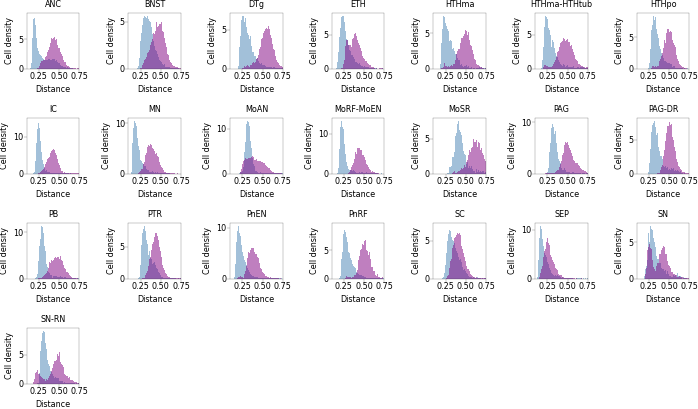

In [319]:
def get_dmax(knn):
    knn = ds.col_graphs.KNN
    dmin = 1 - knn.max(axis=1).toarray()[:, 0]  # Convert to distance since KNN uses similarities
    knn = sparse.coo_matrix((1 - knn.data, (knn.row, knn.col)), shape=knn.shape)
    knn.setdiag(0)
    return knn.max(axis=1).toarray()[:, 0]

with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.Punchcard))
    
plt.figure(None, (10, 10))
gs = plt.GridSpec(7, 7)

# with loompy.connect('/proj/human_adult/20220222/harmony/regions/data/A23_Clean.loom', 'r') as ds:

#     dmax = get_dmax(ds.col_graphs.KNN)
#     punchcard_attr = np.array([cell_dict.get(x, '') for x in ds.ca.CellID])
#     is_neuron = pd.Series(punchcard_attr).str.startswith('harmony_A').to_numpy()
    
#     plt.hist(dmax[is_neuron], bins=100, alpha=0.50, density=True, color='darkorange')

with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_A_A.loom', 'r') as ds:
    all_rois, counts = np.unique(clean_roi(ds.ca.Roi), return_counts=True)
    all_rois = all_rois
    all_rois = pd.Series(all_rois).str.replace("Human ", "").to_numpy()

i = 0
for roi in all_rois:
    
    with loompy.connect(f'/proj/human_adult/20220222/harmony/regions_clean/data/{roi}.loom', 'r') as ds:

        punchcard_attr = np.array([cell_dict.get(x, '') for x in ds.ca.CellID])
        is_neuron = pd.Series(punchcard_attr).str.startswith('harmony_A').to_numpy()
        splatter_neurons = is_neuron & (punchcard_attr == 'harmony_A_A')
        non_splatter_neurons = is_neuron & (punchcard_attr != 'harmony_A_A')
        
        if is_neuron.sum() < 2000:
            continue
        if splatter_neurons.sum() / is_neuron.sum() < 0.20:
            continue
        if non_splatter_neurons.sum() / is_neuron.sum() < 0.20:
            continue

        dmax = get_dmax(ds.col_graphs.KNN)

        plt.subplot(gs[i])
        plt.hist(dmax[non_splatter_neurons], bins=100, alpha=0.50, density=True, color='steelblue')
        plt.hist(dmax[splatter_neurons], bins=100, alpha=0.50, density=True, color='purple')

    plt.xlim(0.1, 0.75)
    plt.title(roi, fontsize=8)
    plt.xlabel('Distance', fontsize=8)
    plt.ylabel('Cell density', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    
    i += 1
    
plt.tight_layout()
plt.savefig(f'{figure_folder}/Hist_dmax.pdf', dpi=300)

# Astrocytes

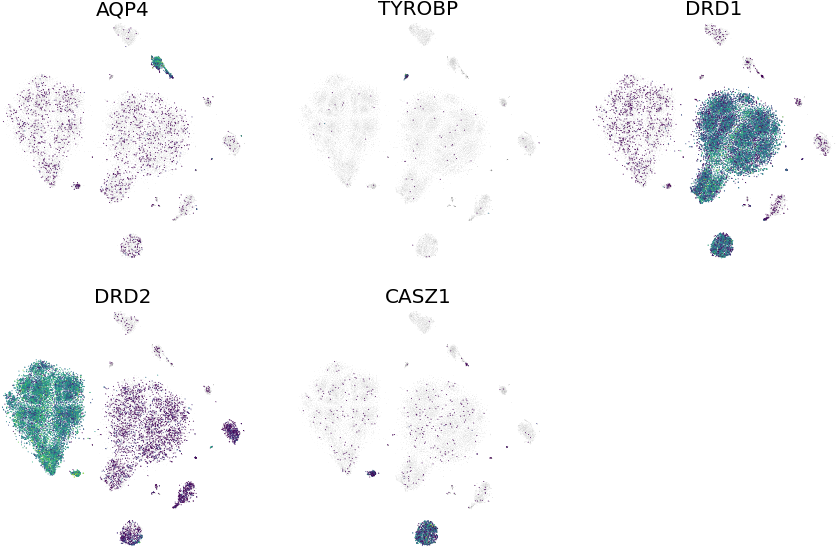

In [26]:
with loompy.connect('/proj/human_adult/20220222/harmony/regions_clean/data/CaB.loom', 'r') as ds:

    plt.figure(None, (15, 15))
    gs = plt.GridSpec(3, 3)

    to_plot = ['AQP4', 'TYROBP', 'DRD1', 'DRD2', 'CASZ1']
    
    for i, g in enumerate(to_plot):
        plt.subplot(gs[i])
        exp = np.log(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        cells = exp > 0
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=1, lw=0, rasterized=True)
        plt.axis('off')
        plt.title(g, fontsize=20)
        plt.margins(0.01, 0.01)
    plt.show()

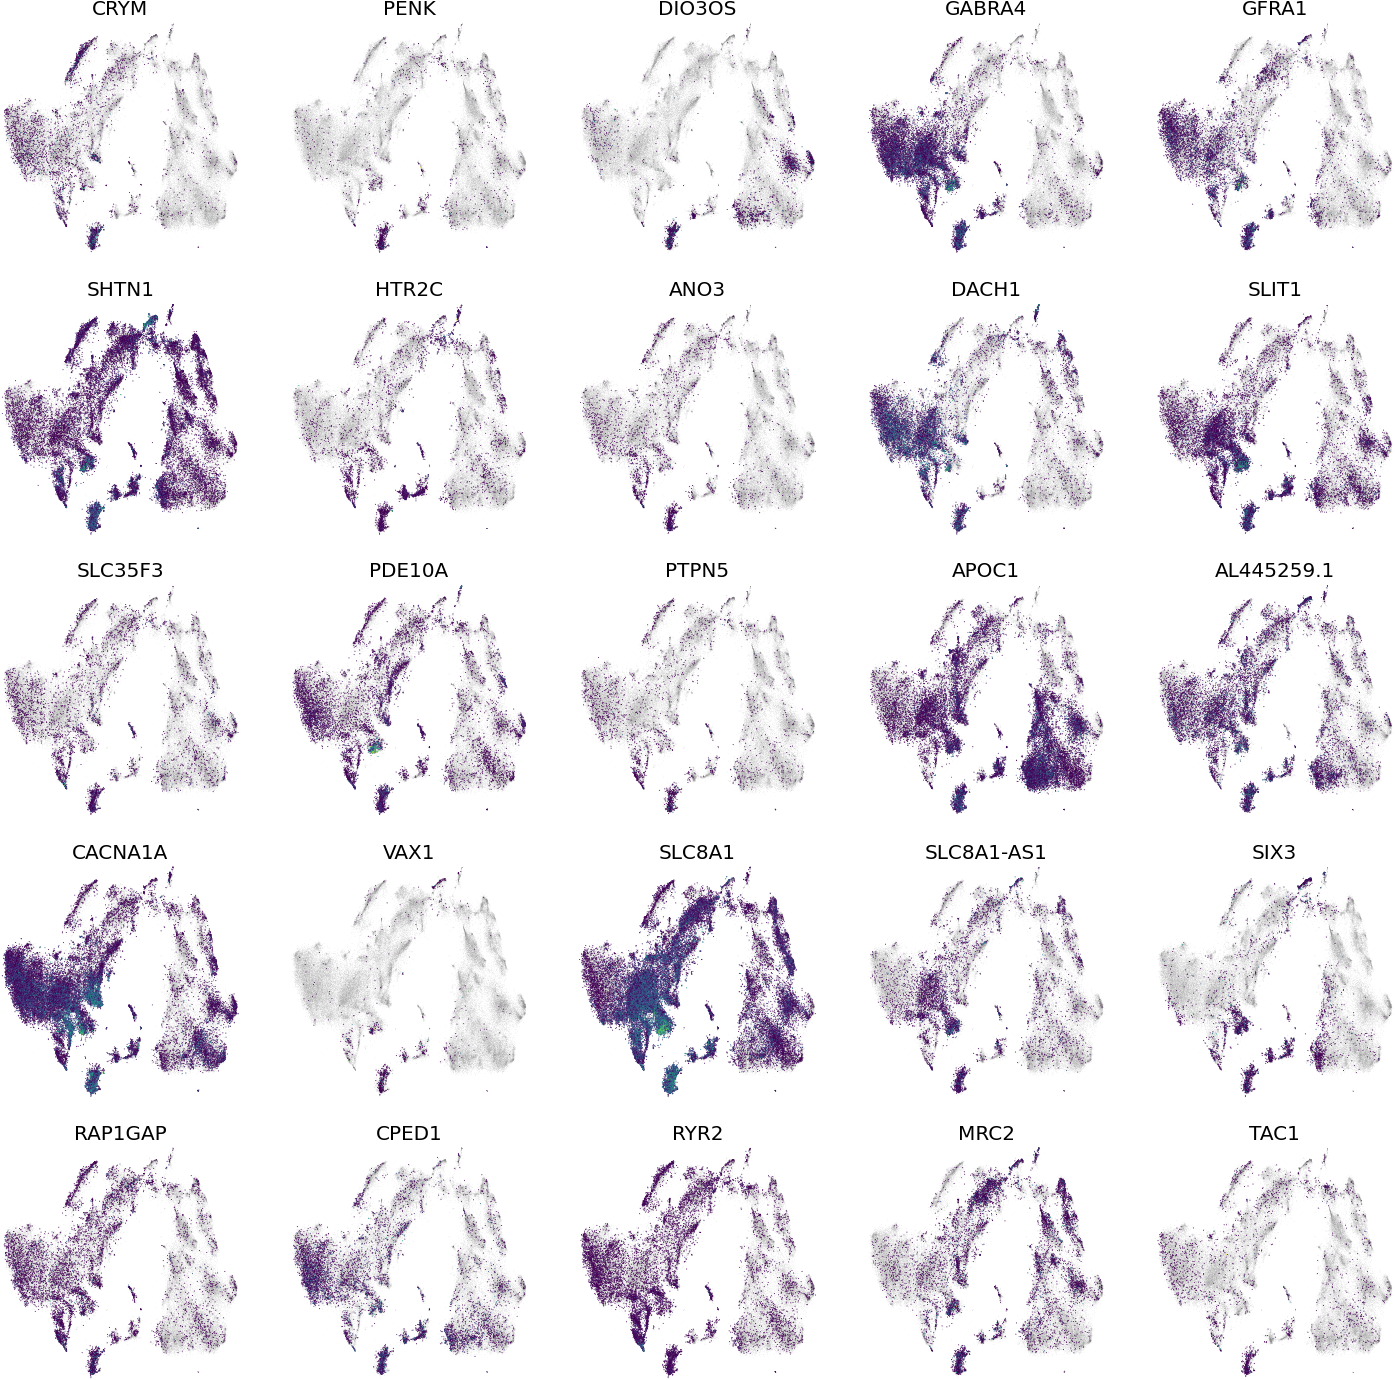

In [165]:
with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_B_C_Clean.agg.loom', 'r') as ds:
    top_genes = ds.ra.Gene[np.argsort(ds['enrichment'][:, 3])[::-1]][:25]

with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_B_C_Clean.loom', 'r') as ds:

    plt.figure(None, (25, 25))
    gs = plt.GridSpec(5, 5)

    to_plot = top_genes
    
    
    for i, g in enumerate(to_plot):
        plt.subplot(gs[i])
        exp = np.log(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        cells = exp > 0
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=1, lw=0, rasterized=True)
        plt.axis('off')
        plt.title(g, fontsize=20)
        plt.margins(0.01, 0.01)
    plt.show()

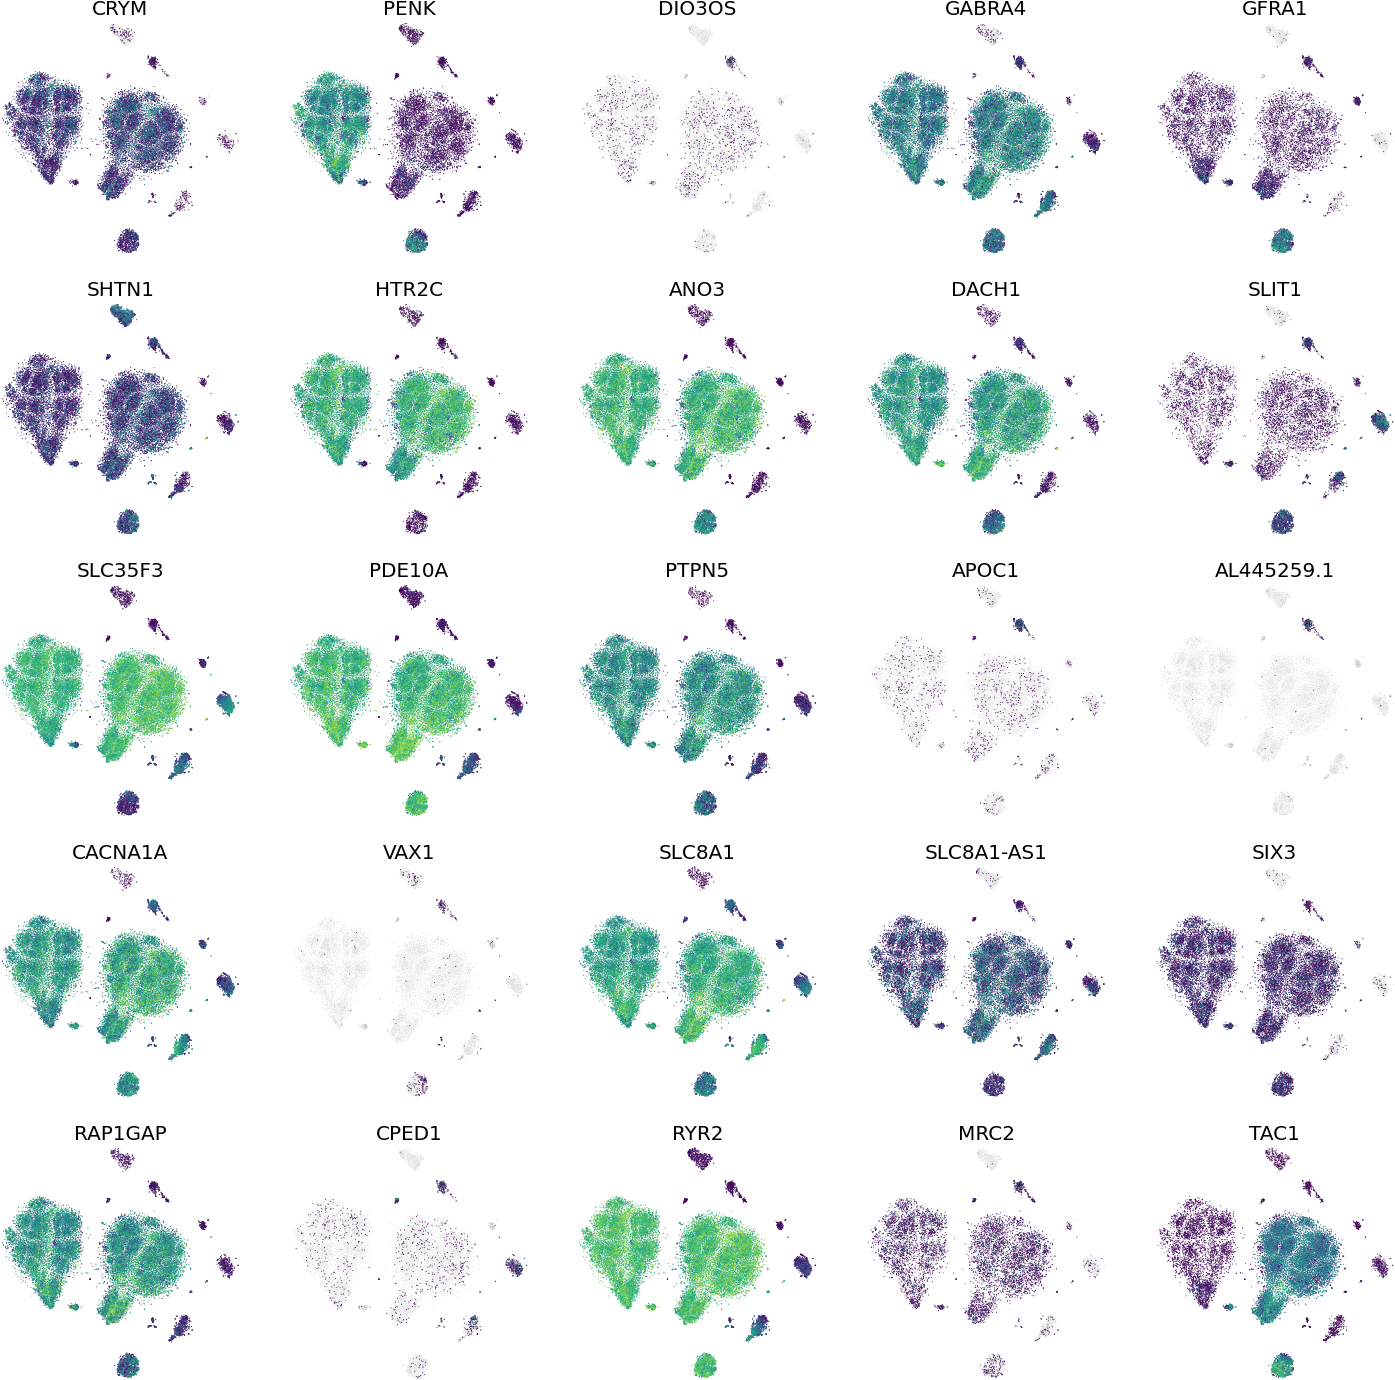

In [166]:
with loompy.connect('/proj/human_adult/20220222/harmony/regions_clean/data/CaB.loom', 'r') as ds:

    plt.figure(None, (25, 25))
    gs = plt.GridSpec(5, 5)

    to_plot = top_genes
    
    
    for i, g in enumerate(to_plot):
        plt.subplot(gs[i])
        exp = np.log(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        cells = exp > 0
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=1, lw=0, rasterized=True)
        plt.axis('off')
        plt.title(g, fontsize=20)
        plt.margins(0.01, 0.01)
    plt.show()

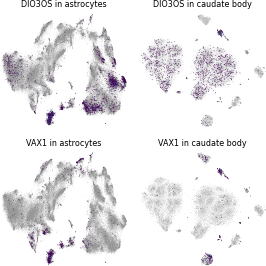

In [335]:
plt.figure(None, (4, 4))
gs = plt.GridSpec(2, 2)

i = 0
for g in ['DIO3OS', 'VAX1']:
    
    with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_B_C_Clean.loom', 'r') as ds:
        plt.subplot(gs[i])
        exp = np.log(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        cells = exp > 0
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=0.5, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=0.5, lw=0, rasterized=True)
        plt.axis('off')
        plt.title(f'{g} in astrocytes', fontsize=8)
        plt.margins(0.01, 0.01)
        
    i += 1
    
    with loompy.connect('/proj/human_adult/20220222/harmony/regions_clean/data/CaB.loom', 'r') as ds:
        plt.subplot(gs[i])
        exp = np.log(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        cells = exp > 0
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=0.5, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=0.5, lw=0, rasterized=True)
        plt.axis('off')
        plt.title(f'{g} in caudate body', fontsize=8)
        plt.margins(0.01, 0.01)
        
    i += 1

plt.tight_layout()
plt.savefig(f'{figure_folder}/Astrocytes_StriatalMarkers.pdf', dpi=300)

# Splatter neurons within developmental regions

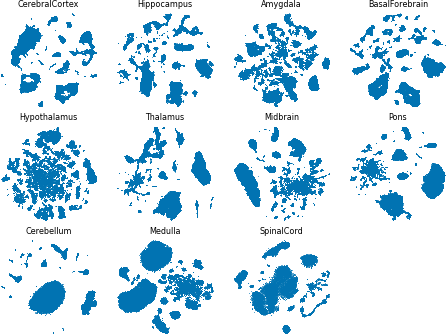

In [22]:
plt.figure(None, (8, 8))
gs = plt.GridSpec(4, 4)

i = 0

region_list = ['CerebralCortex', 'Hippocampus', 'Amygdala', 'BasalForebrain', 'Hypothalamus', 'Thalamus', 
               'Midbrain', 'Pons', 'Cerebellum', 'Myelencephalon', 'SpinalCord']

for region in region_list:

    with loompy.connect(f'/proj/human_adult/20220222/harmony/roi_groups/data/harmony_{region}.loom', 'r') as ds:

        plt.subplot(gs[i])
        # punchcard_attr = np.array([cell_dict.get(x, '') for x in ds.ca.CellID])
        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c=cbl[0], s=0.5, lw=0, rasterized=True)
        plt.axis('off')
        t = 'Medulla' if region == 'Myelencephalon' else region 
        plt.title(t, fontsize=8)
        plt.margins(0.01, 0.01)

    i += 1

plt.savefig(f'{figure_folder}/RegionBuilds.pdf', dpi=300)

# Oligo1/2 and OPC1/2 on the oligolineage UMAP

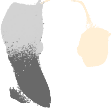

In [341]:
plt.figure(None, (2, 2))

with loompy.connect(folder + 'harmony_B_A.agg.loom', 'r') as ds:
    clades = hc.cut_tree(ds.attrs.linkage, 2)

with loompy.connect(folder + 'harmony_B_A.loom', 'r') as ds:

    labels = clades[ds.ca.Clusters].flatten()
    colors = np.array(['dimgray' if l == 0 else 'lightgray' for l in labels])
    
    color_dict = dict(zip(ds.ca.CellID, colors))

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean.loom', 'r') as ds:

    colors = np.array([color_dict.get(x, 'papayawhip') for x in ds.ca.CellID])
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.UMAP[cells, 0], ds.ca.UMAP[cells, 1], c=colors[cells], s=1, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig(f'{figure_folder}/oligolineage_umap_OligoTypes.pdf', dpi=300)

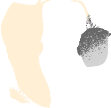

In [342]:
plt.figure(None, (2, 2))

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.agg.loom', 'r') as ds:
    clades = hc.cut_tree(ds.attrs.linkage, 2)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

    labels = clades[ds.ca.Clusters].flatten()
    colors = np.array(['dimgray' if l == 1 else 'lightgray' for l in labels])
    
    color_dict = dict(zip(ds.ca.CellID, colors))

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean.loom', 'r') as ds:

    colors = np.array([color_dict.get(x, 'papayawhip') for x in ds.ca.CellID])
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.UMAP[cells, 0], ds.ca.UMAP[cells, 1], c=colors[cells], s=1, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig(f'{figure_folder}/oligolineage_umap_OpcTypes.pdf', dpi=300)

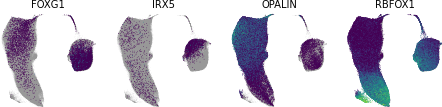

In [25]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean.loom', 'r') as ds:

    plt.figure(None, (10, 10))
    gs = plt.GridSpec(5, 5)

    to_plot = ['FOXG1', 'IRX5', 'OPALIN', 'RBFOX1']
    
    for i, g in enumerate(to_plot):
        plt.subplot(gs[i])
        exp = np.log(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        cells = exp > 0
        plt.scatter(ds.ca.UMAP[:, 0], ds.ca.UMAP[:, 1], color='grey', alpha=0.05, s=0.5, lw=0, rasterized=True)
        plt.scatter(ds.ca.UMAP[cells, 0], ds.ca.UMAP[cells, 1], c=exp[cells], s=0.5, lw=0, rasterized=True)
        plt.axis('off')
        plt.title(g, fontsize=10)
        plt.margins(0.01, 0.01)
    plt.show()